### Get data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/ml4f_project/src'

/content/drive/MyDrive/ml4f_project/src


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, zscore, normaltest, norm

from statsmodels.tsa.stattools import acf

from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from keras.utils.vis_utils import plot_model
from tqdm.keras import TqdmCallback

from gan import GAN
from preprocess import Gaussianize, rolling_window
from metrics import le_score, emd_score



In [2]:
tick = 'BTC'
raw_data = pd.read_csv(f'../data/{tick}USD_1m_2015_01_01_now.csv')
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'])
raw_data = raw_data.set_index('Timestamp')
logret = np.log(raw_data['Close']).diff().resample('D').sum()
logret = logret[logret.index <= '2021-05-01'].dropna().to_numpy()
logret.shape

### Prepare data

/content/drive/My Drive/ml4f_project/src/preprocess.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)


7.376407201056488e-07 8
loc: 0.000000, scale: 1.000000
kurtosis: 3.000001
NormaltestResult(statistic=0.6769332770280526, pvalue=0.712862561146523)


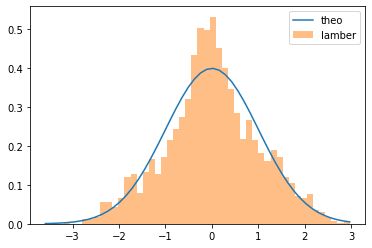

In [ ]:
gauss = Gaussianize()
gauss.fit(logret)
u = gauss.transform(logret)

loc, scale = norm.fit(u)
print(f'loc: {loc:.6f}, scale: {scale:.6f}')
print(f'kurtosis: {kurtosis(u, fisher=False):.6f}')
print(normaltest(u))
xmin, xmax = u.min(), u.max()
x = np.linspace(xmin, xmax)
plt.plot(x, norm.pdf(x, loc, scale), label='theo')
plt.hist(u, alpha=0.5, bins=50, label='lamber', density=True)
plt.legend()
plt.show()



In [ ]:
data = rolling_window(u, 127, 1)
data = np.expand_dims(data, 2)
print(data.shape)

batch_size = 256
data = tf.cast(data, tf.float32)
dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

(2187, 127, 1)


In [ ]:
latent_size = 3
hidden_size = 80
output_size = 1
d_train_steps = 5


In [ ]:
gan = GAN(latent_size, hidden_size, output_size, 5, 0)

g_optimizer = keras.optimizers.Adam()
d_optimizer = keras.optimizers.Adam()

gan.compile(
    d_optimizer=g_optimizer,
    g_optimizer=d_optimizer,
    loss_fn=keras.losses.BinaryCrossentropy(),
    use_reduce_loss=params['use_reduce_loss']
)

plot_model(gan.discriminator.tcn.model(input_shape=(None, 127, 1)))
  

### Functions

In [8]:
def build_model(params):
  gan = GAN(latent_size, hidden_size, output_size, 
            params['d_train_steps'], params['gp_weight'])

  g_optimizer = keras.optimizers.Adam(learning_rate=params['g_lr'], 
                                      beta_1=params['g_b1'], 
                                      beta_2=params['g_b2'])
  d_optimizer = keras.optimizers.Adam(learning_rate=params['d_lr'], 
                                      beta_1=params['d_b1'], 
                                      beta_2=params['d_b1'])

  gan.compile(
      d_optimizer=g_optimizer,
      g_optimizer=d_optimizer,
      loss_fn=keras.losses.BinaryCrossentropy(),
      use_reduce_loss=params['use_reduce_loss']
  )
  return gan


def get_train_losses(model, epochs):
  history = model.fit(dataset, epochs=epochs, 
                    verbose=0, 
                    callbacks=[TqdmCallback(verbose=1)])
  return {"g_loss": history.history['g_loss'][-1], 
          "d_loss": history.history['d_loss'][-1]}


def average_model_train(params, n_steps=10):
  g_loss, d_loss = 0, 0
  for _ in range(n_steps):
    model = build_model(params)
    res = get_train_losses(model, 15)
    g_loss += res["g_loss"]
    d_loss += res["d_loss"]

  return {"g_loss": g_loss / n_steps, 
          "d_loss": d_loss / n_steps}

def grid_search(param_set, n_steps=10):
  hist = {}
  for i, params in enumerate(param_set):
    losses = average_model_train(params, n_steps)
    hist[f"params_{i}"] = {"params": params, 
                        "g_loss": losses["g_loss"],
                        "d_loss": losses["d_loss"]}
    print(f"params_{i}: g_loss = {losses['g_loss']}, d_loss = {losses['d_loss']}")
  return hist

In [9]:
def plot_results(fake, name):
  loc, scale = norm.fit(fake)
  fake -= loc
  print(f'loc: {loc:.6f}, scale: {scale:.6f}')
  print(f'kurtosis: {kurtosis(fake, fisher=False):.6f}')
  print(f'kurtosis: {kurtosis(u, fisher=False):.6f}')
  print(normaltest(fake))
  plt.figure(figsize=(10, 6))
  plt.ylabel('Density')
  plt.hist([fake, u], bins=50, label=['fake', 'real'], density=True)
  plt.legend()
  plt.savefig(f'{name}.pdf')
  plt.show()

In [10]:
def lagged_returns(returns, lag):
  return np.diff(returns, lag)

def dependence_score(historical, generated_set, s, mode, func=None):
    if func is None:
        def func(x): return x

    acf_hist = acf_(func(historical), s, mode)
    acf_gen = np.array([acf_(func(gen), s, mode) for gen in generated_set])
    return np.linalg.norm(acf_hist - acf_gen.mean(axis=0))


def acf_score(historical, generated_set, s, func=None):
    if func is None:
        def func(x): return x

    acfs = [acf(func(generated_set[i, :]), nlags=s, fft=False)[1:] for i in range(generated_set.shape[0])]
    mean_acf = np.array(acfs).mean(axis=0)
    return np.linalg.norm(acf(func(historical), nlags=s, fft=False)[1:] - mean_acf)
  

def le_score(historical, generated_set, s):
  return dependence_score(historical, generated_set, s, 'le')


def get_metrics_for_model(model, data, transform, M=500, T=2432, S=250, lags=[1,5,20,100]):
  """T: number of samples per path
     M: number of path to generate"""
  results = {}
  fake_set = []
  fake_set = model.generator(tf.random.normal(shape=(M, T, 3))).numpy()

  fake_set = np.apply_along_axis(transform.inverse_transform, 0, fake_set)
  data = transform.inverse_transform(data)
  
  for l in lags:
    hist_lagged = lagged_returns(data, l)
    gen_lagged = lagged_returns(np.squeeze(fake_set.mean(axis=0)), l)
    results[f'emd_{l}'] = emd_score(hist_lagged, gen_lagged)
  

  funcs = [None, np.abs, lambda x: x**2]
  fname = ['id', 'abs', 'sq']
  for f, name in zip(funcs, fname):
    results[f'acf_{name}'] = acf_score(data, fake_set, S, func=f)

  # results['le'] = le_score(data, fake_set, S)

  return results

In [11]:
def train_model_with_params(params, name, epochs=10, T=2433, plot=True):
  gan = GAN(latent_size, hidden_size, output_size, 
            params['d_train_steps'], params['gp_weights'],
            tcn_skip=params['tcn_skip'], block_skip=params['block_skip'])

  if params['opt'] == 'adam':
    g_optimizer = keras.optimizers.Adam(learning_rate=params['g_lr'], 
                                        beta_1=params['g_b1'], 
                                        beta_2=params['g_b2'])
    d_optimizer = keras.optimizers.Adam(learning_rate=params['d_lr'], 
                                        beta_1=params['g_b1'], 
                                        beta_2=params['g_b2'])
  else:
    g_optimizer = keras.optimizers.RMSprop(params['g_lr'])
    d_optimizer = keras.optimizers.RMSprop(params['d_lr'])

  gan.compile(
    d_optimizer=g_optimizer,
    g_optimizer=d_optimizer,
    loss_fn=keras.losses.BinaryCrossentropy(),
    use_reduce_loss=params['use_reduce_loss']
  )

  checkpoint_filepath = f'../models/{name}'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='g_loss',
      mode='max',
      save_best_only=True)

  history = gan.fit(dataset, epochs=epochs, verbose=0,
                    callbacks=[TqdmCallback(verbose=1), model_checkpoint_callback])
  if plot:
    latent_noise = tf.random.normal(shape=(1, T, 3))
    fake = gan.generator(latent_noise).numpy().reshape(T)
    plot_results(fake, name)
  return gan

### Grid search

In [12]:
# param_set_binary = {
#     'd_train_steps': [5], 'gp_weight': [0], 'use_reduce_loss': [False],
#     'g_lr': np.linspace(0.0001, 0.0002, 5), 'g_b1': [0], 'g_b2': [0.9],
#     'd_lr': np.linspace(0.0001, 0.0002, 5), 'd_b1': [0], 'd_b2': [0.9],
# }

# param_grid = list(ParameterGrid(param_set_binary))
# hist = grid_search(param_grid, 1)

### Adam, with gradient penalty, TCN skips

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: 0.164338, scale: 1.118734
kurtosis: 2.766475
kurtosis: 3.000001
NormaltestResult(statistic=12.13809422424753, pvalue=0.0023133765491349604)


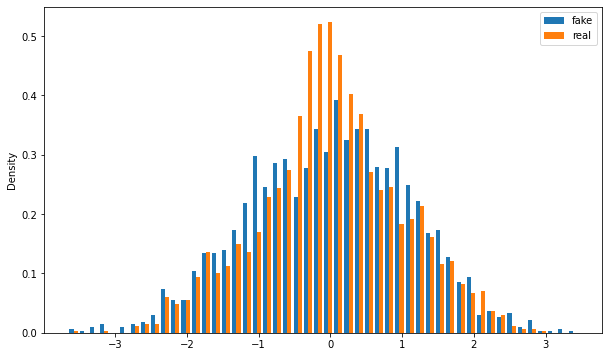

In [29]:
adam_binary_tcn_gp = {
    'd_train_steps': 5, 'gp_weights': 1, 'use_reduce_loss': False,
    'g_lr': 0.001, 'g_b1': 0.5, 'g_b2': 0.9,
    'd_lr': 0.001, 'd_b1': 0.5, 'd_b2': 0.9,
    'tcn_skip': True, 'block_skip': False,
    'opt': 'adam'
}

adam_binary_tcn_gp = train_model_with_params(adam_binary_tcn_gp, 'adam_binary_tcn_gp', T=logret.shape[0])

### Adam, with gradient penalty, residual skips

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: -0.477002, scale: 1.205318
kurtosis: 3.158720
kurtosis: 3.000001
NormaltestResult(statistic=8.832015541810286, pvalue=0.012082371724885174)


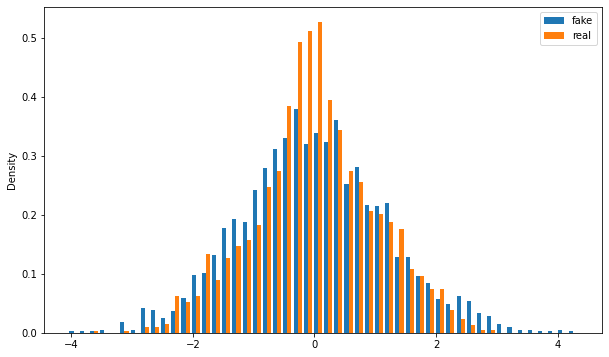

In [14]:
adam_binary_res_gp = {
    'd_train_steps': 5, 'gp_weights': 0.01, 'use_reduce_loss': False,
    'g_lr': 0.0002, 'g_b1': 0.5, 'g_b2': 0.9,
    'd_lr': 0.0001, 'd_b1': 0.5, 'd_b2': 0.9,
    'tcn_skip': False, 'block_skip': True,
    'opt': 'adam'
}

adam_binary_res_gp = train_model_with_params(adam_binary_res_gp, 'adam_binary_res_gp', T=logret.shape[0])

### RMSProp, with gradient penalty, residual skips

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: 0.028207, scale: 0.006977
kurtosis: 37.422142
kurtosis: 3.000001
NormaltestResult(statistic=1913.3934082179585, pvalue=0.0)


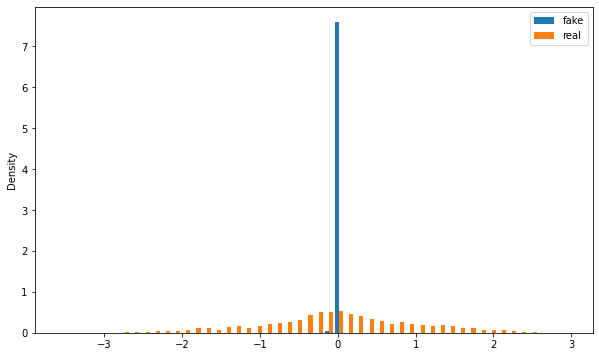

In [30]:
rms_binary_res_gp = {
    'd_train_steps': 5, 'gp_weights': 1, 'use_reduce_loss': False,
    'g_lr': 0.001, 'd_lr': 0.001,
    'tcn_skip': False, 'block_skip': True,
    'opt': 'rms'
}

rms_binary_res_gp = train_model_with_params(rms_binary_res_gp, 'rms_binary_res_gp', T=logret.shape[0])

### RMSProp, with gradient penalty, TCN skips

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: 0.095783, scale: 0.702953
kurtosis: 2.932206
kurtosis: 3.000001
NormaltestResult(statistic=136.6234516340711, pvalue=2.150772269553955e-30)


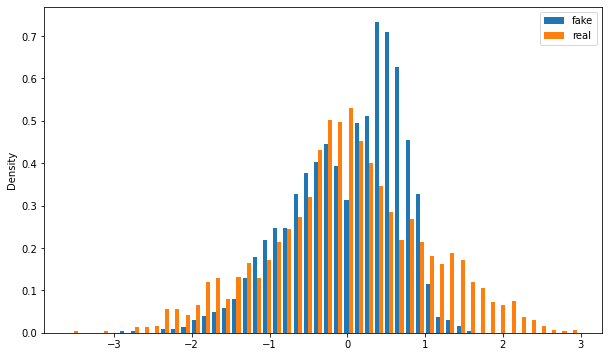

In [31]:
rms_binary_tcn_gp = {
    'd_train_steps': 5, 'gp_weights': 10, 'use_reduce_loss': False,
    'g_lr': 0.001, 'd_lr': 0.001,
    'tcn_skip': True, 'block_skip': False,
    'opt': 'rms'
}

rms_binary_tcn_gp = train_model_with_params(rms_binary_tcn_gp, 'rms_binary_tcn_gp', T=logret.shape[0])

### Why no try both skips?

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: -0.147861, scale: 1.152180
kurtosis: 2.883809
kurtosis: 3.000001
NormaltestResult(statistic=1.3115472483378678, pvalue=0.5190403650545644)


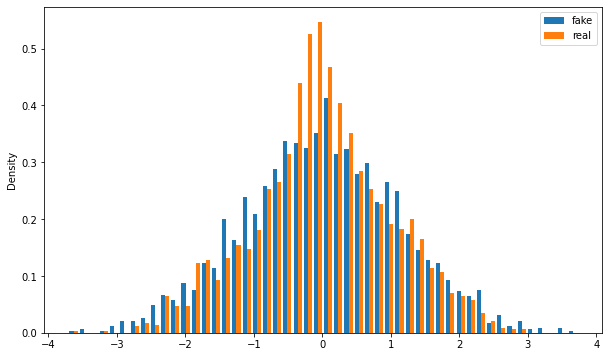

In [32]:
adam_binary_doubleskip_gp = {
    'd_train_steps': 5, 'gp_weights': 1, 'use_reduce_loss': False,
    'g_lr': 0.0001, 'g_b1': 0.5, 'g_b2': 0.9,
    'd_lr': 0.0002, 'd_b1': 0.5, 'd_b2': 0.9,
    'tcn_skip': True, 'block_skip': True,
    'opt': 'adam'
}

adam_binary_doubleskip_gp = train_model_with_params(adam_binary_doubleskip_gp, 'adam_binary_doubleskip_gp', T=logret.shape[0])

### Wasserstein 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: 1.891439, scale: 0.671792
kurtosis: 8.962311
kurtosis: 3.000001
NormaltestResult(statistic=460.88749198724486, pvalue=8.309075895528072e-101)


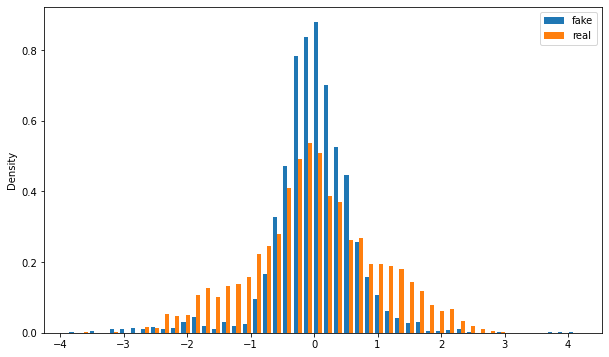

In [33]:
adam_reduce_blockskip_gp = {
    'd_train_steps': 5, 'gp_weights': 10, 'use_reduce_loss': True,
    'g_lr': 0.0001, 'g_b1': 0.5, 'g_b2': 0.9,
    'd_lr': 0.0001, 'd_b1': 0.5, 'd_b2': 0.9,
    'tcn_skip': False, 'block_skip': True,
    'opt': 'adam'
}

adam_reduce_blockskip_gp = train_model_with_params(adam_reduce_blockskip_gp, 'adam_reduce_blockskip_gp', T=logret.shape[0])

### Get metrics

In [34]:
get_metrics_for_model(adam_reduce_blockskip_gp, u, gauss, T=logret.shape[0], M=500) 

{'acf_abs': 1.054362207875561,
 'acf_id': 1.01996547670473,
 'acf_sq': 0.5965371147559685,
 'emd_1': 0.055869868845906626,
 'emd_100': 1.8555195508101677e+28,
 'emd_20': 18085.152856262204,
 'emd_5': 0.682822385024144}

In [35]:
get_metrics_for_model(adam_binary_doubleskip_gp, u,  gauss, T=logret.shape[0])

{'acf_abs': 0.8551375176421628,
 'acf_id': 0.33052948269978943,
 'acf_sq': 0.2858238344493358,
 'emd_1': 0.035836605989475426,
 'emd_100': 8.389987214174521e+27,
 'emd_20': 9813.855950129779,
 'emd_5': 0.4135720051958626}

In [36]:
get_metrics_for_model(rms_binary_tcn_gp, u, gauss, T=logret.shape[0])

{'acf_abs': 0.8556533096091755,
 'acf_id': 0.32912506283907567,
 'acf_sq': 0.2855414292724844,
 'emd_1': 0.037915093211162765,
 'emd_100': 8.931897042925949e+27,
 'emd_20': 10440.815463503635,
 'emd_5': 0.4383721158033095}

In [37]:
get_metrics_for_model(rms_binary_res_gp, u, gauss, T=logret.shape[0])

{'acf_abs': 3.5224919360005633,
 'acf_id': 3.6791825906965645,
 'acf_sq': 3.6705115699866186,
 'emd_1': 0.03894973886201955,
 'emd_100': 9.133339135556791e+27,
 'emd_20': 10693.905621405269,
 'emd_5': 0.4496908182160416}

In [38]:
get_metrics_for_model(adam_binary_res_gp, u, gauss, T=logret.shape[0])

{'acf_abs': 0.7938638613307719,
 'acf_id': 0.4956070317983392,
 'acf_sq': 0.27658996417391296,
 'emd_1': 0.03261404204633609,
 'emd_100': 7.856370062428458e+27,
 'emd_20': 9029.668759562537,
 'emd_5': 0.3758457433580147}

In [39]:
get_metrics_for_model(adam_binary_tcn_gp, u, gauss, T=logret.shape[0])

{'acf_abs': 0.849187439499064,
 'acf_id': 0.3583731827263522,
 'acf_sq': 0.28347365819768994,
 'emd_1': 0.03592734384067879,
 'emd_100': 8.354841070226938e+27,
 'emd_20': 9757.388632996119,
 'emd_5': 0.41274887361949053}